In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import resize
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os

import torch
import torchvision
import torchvision.datasets as datasets

I use torch vision to handle the load of the entire MNIST dataset

In [2]:
data_train = torchvision.datasets.MNIST(root='./data', train=True, transform=None, target_transform=None, download=True)
data_eval = torchvision.datasets.MNIST(root='./data', train=False, transform=None, target_transform=None, download=True)

Converting the train & evaluation sets to numpy arrays for manipulation

In [3]:
train_images_raw = data_train.data.numpy()
train_labels = data_train.targets.numpy()
eval_images_raw = data_eval.data.numpy()
eval_labels = data_eval.targets.numpy()

Chcecking the shapes of the train & evaluation matrices

In [4]:
print(train_images_raw.shape)
print(eval_images_raw.shape)

(60000, 28, 28)
(10000, 28, 28)


When working with images, pixel formats are stored in an 8-bit integer, whose values range between 0 and 255, where 0 is completely dark (or black), and 255 is white.

In [5]:
train_images_raw.dtype

dtype('uint8')

In [6]:
train_images_raw[0].min(), train_images_raw[0].max()

(0, 255)

In [7]:
train_labels.shape, eval_labels.shape, train_labels.dtype, 

((60000,), (10000,), dtype('int64'))

Performing sanity check on the number of classes

In [8]:
train_labels[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

Checking an individual image, and the type of array we get

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 18, 18, 126, 136, 175, 26, 166, 255, 247, 127, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 30, 36, 94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195, 64, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251, 93, 82, 82, 56, 39, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 80, 156, 107, 253, 253, 205, 11, 0, 43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 154, 25

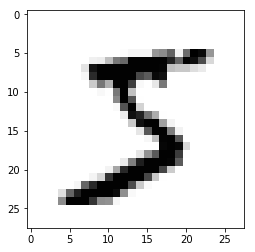

In [9]:
for row_img in train_images_raw[0]:
    print(row_img.tolist())
    
plt.imshow(train_images_raw[0], cmap='Greys')

When applying a threshold, we extract the darkest pixels based on the established benchmark, as shown below.

In [10]:
def get_thresholded(images_raw, threshold):
    """
    Perform image thresholding.

    Parameters:
            images_raw (np,array): Do not assume anything about its shape, dtype or range of values. 
            Your function should be careless about these attributes.
            threshold (int): A scalar value.

    Returns:
            threshed_image (np.array): A numpy array with the same shape as images_raw, and the bool dtype. 
            This array should indicate whether each elemelent of images_raw is greater than or equal to 
            threshold.
    About the return array:
     A numpy array with the same shape as `images_raw`, and the `bool` dtype. This array should 
     indicate whether each elemelent of `images_raw` is **greater than or equal to**  `threshold`.
                
    """    

    threshed_image = images_raw >= threshold
   
    
    return threshed_image

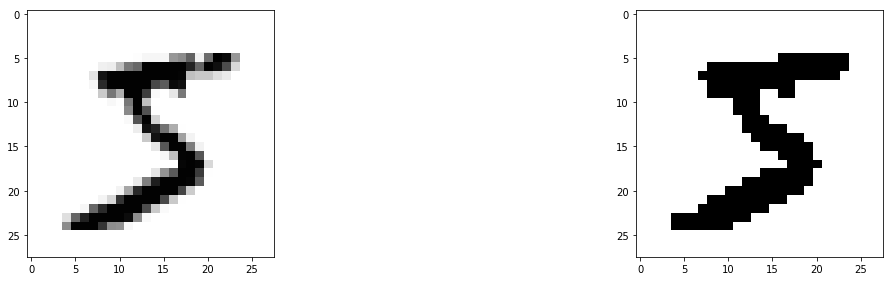

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_images_raw[0], cmap='Greys')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_images_threshed[0], cmap='Greys')

In [12]:
train_images_threshed = get_thresholded(train_images_raw, threshold=20)
eval_images_threshed = get_thresholded(eval_images_raw, threshold=20)

In order to get a proper image classification, we need to do some data fansformations that include to resize the images, and test the Naive Bayes algorithm with the image as is, a bounding box, or a stretched image

Creating a Bonding-Box image preprocessing: For this task, we need to find the rows and columns with any dark pixels.

In [15]:
def get_is_row_inky(images):
    """
    Finds the rows with ink pixels.

        Parameters:
        images (np,array): A numpy array with the shape (N, height, width)

        Returns:
        is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype. 
        
        is_row_inky: A numpy array with the shape `(N, height)`, and the `bool` dtype. 
    is_row_inky[i,j] should be True if **any** of the pixels in the `j`th row of the 
    `i`th image was an ink pixel, and False otherwise.
    
    images = N * h * w
    
    """
    is_row_inky = images.sum(axis=2) >=1
    
    
    return is_row_inky

Next, the columns with dark pixels is needed

In [16]:
def get_is_col_inky(images):
    """
    Finds the columns with ink pixels.

        Parameters:
        images (np.array): A numpy array with the shape (N,height,width).
                
        Returns:
        is_col_inky (np.array): A numpy array with the shape (N, width), and the bool dtype. 
        
        is_col_inky[i,j] should be True if **any** of the pixels in the `j`th column of the 
        `i`th image was an ink pixel, and False otherwise.
        
    """
    
    is_col_inky = images.sum(axis=1) >= 1

    return is_col_inky

Now, in order to crop the box, I need to find what is the first dark row containing dark pixels, through the following function.

In [17]:
def get_first_ink_row_index(is_row_inky):
    """
     Finds the first row containing ink pixels

        Parameters:
        is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype. 
        This is the output of the get_is_row_inky function that you implemented before.
                
        Returns:
        first_ink_rows (np.array): A numpy array with the shape (N,), and the int64 dtype.
        
        first_ink_rows[i]` is the index of the first row containing any ink pixel in the 
        `i`th image. The indices should be **zero-based**.
        In other words, get the index of the first row, for all rows in the array
        
    """
    
    first_ink_rows = np.argmax(is_row_inky, axis=1)
    
    return first_ink_rows

In a similar fashion, we can follow the same data structure to extract the first dark pixels indices for all columns. Like we did in the previous function, we use the return array(is_col_inky) from the get_is_col_inky function implemented before.

In [18]:
def get_first_ink_col_index(is_col_inky):
    return get_first_ink_row_index(is_col_inky)

Now, let's just find the last row containing dark pixels.

In [19]:
def get_last_ink_row_index(is_row_inky):
    """
    Finds the last row containing ink pixels.

        Parameters:
        is_row_inky (np.array): A numpy array with the shape (N, height), and the bool dtype. 
        This is the output of the get_is_row_inky function that you implemented before.
                
        Returns:
        last_ink_rows (np.array): A numpy array with the shape (N,), and the int64 dtype.
        
        `last_ink_rows[i]` is the index of the last row containing any ink pixel in the 
        `i`th image. The indices should be **zero-based**.
        
    """    

#     j = np.transpose(np.nonzero(is_row_inky))
#     k = np.unique(j, axis=0)
#     k = np.array(k)
    
#     j_idx = np.lexsort(k[:,[1,0]].T)
#     idx = np.append(np.flatnonzero(k[1:,0] > k[:-1,0]), k.shape[0]-1)
#     res_matrix = k[j_idx[idx]]
#     last_ink_rows = res_matrix[:,1]

    # don't need lexsort though
    k = np.transpose(np.nonzero(is_row_inky))
    idx = np.append(np.flatnonzero(k[1:,0] > k[:-1,0]), k.shape[0]-1)
    last_ink_rows = k[idx, 1]
    
    return last_ink_rows

Similarly, we get the last column containing dark pixeks, following the same data structure as before

In [20]:
def get_last_ink_col_index(is_col_inky):
    return get_last_ink_row_index(is_col_inky)

Final Bounding Box Pre-Processor

We define the **inky middle row/column** of the raw image.

 * The **inky middle row** of the raw image is $r_m = \lfloor \frac{r_1 + r_2 + 1}{2} \rfloor$. In this example, we have $r_m=16$, which is also shown in the picture.
 * The **inky middle column** of the raw image is $c_m = \lfloor \frac{c_1 + c_2 + 1}{2} \rfloor$. In this example, we have $c_m=13$, which is also shown in the picture.


The middle row index of the output image is $r_{out} = \lfloor \frac{\text{bb_size}}{2} \rfloor$. Similarly, we have the middle column index of the output image $c_{out} = \lfloor \frac{\text{bb_size}}{2} \rfloor$. In this example, we have $r_{out}=c_{out}=10$, which are marked with blue boxes in the solution image.

The **middle inky pixel of the raw image** is `X[r_m, c_m]`. This middle inky pixel is colored red in the raw image for clarification.

The **middle inky pixel of the solution image** is `Y[r_out, c_out]`. This middle inky pixel is colored red in the solution image for clarification

We shift the raw image in a way that the **middle inky pixel of the raw image** gets placed on the **middle inky pixel of the solution image**. In other words, the red pixels should be placed on top of each other.

In [21]:
def get_images_bb(images, bb_size=20):
    """
    Applies the "Bounding Box" pre-processing step to images.

        Parameters:
                images (np.array): A numpy array with the shape (N,height,width)
                
        Returns:
                images_bb (np.array): A numpy array with the shape (N,bb_size,bb_size), 
                and the same dtype as images. 
    """
    
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll add a dummy dimension to be consistent
        images_ = images.reshape(1,*images.shape)
    else:
        # Otherwise, we'll just work with what's given
        images_ = images
        
    is_row_inky = get_is_row_inky(images_)
    is_col_inky = get_is_col_inky(images_)
    
    first_ink_rows = get_first_ink_row_index(is_row_inky)
    last_ink_rows = get_last_ink_row_index(is_row_inky)
    first_ink_cols = get_first_ink_col_index(is_col_inky)
    last_ink_cols = get_last_ink_col_index(is_col_inky)
    
    
    r_m = (first_ink_rows + last_ink_rows + 1) // 2
    c_m = (first_ink_cols + last_ink_cols + 1) // 2
    
    r_out = bb_size // 2
    c_out = bb_size // 2
    
    images_bb = []
    for i, img in enumerate(images):
        img = np.roll(img, (r_out - r_m[i], c_out - c_m[i]), axis=(0, 1))
        img = img[:bb_size, :bb_size]
        images_bb.append(img)
    images_bb = np.array(images_bb)
    
    
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll get rid of the dummy dimension
        return images_bb[0]
    else:
        # Otherwise, we'll just work with what's given
        return images_bb

In [22]:
train_images_bb = get_images_bb(train_images_threshed)
eval_images_bb = get_images_bb(eval_images_threshed)

Testing implementation on first image to construct a bounding box

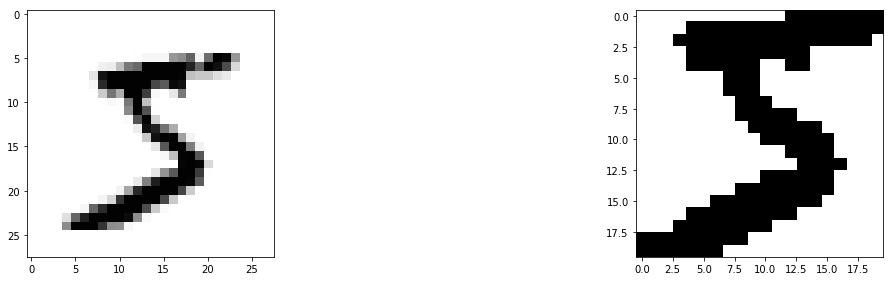

In [23]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_images_raw[0], cmap='Greys')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_images_bb[0], cmap='Greys')

Buiding a the final Stretched Bounding-Box Pre-processor

The stretched bounding-box should find a tight-canvas of the inky area in each input image, and stretch it out to fill the full height and width of the output bounding-box.

In [24]:
def get_images_sbb(images, bb_size=20):
    """
    Applies the "Stretched Bounding Box" pre-processing step to images.

        Parameters:
                images (np.array): A numpy array with the shape (N,height,width)
                
        Returns:
                images_sbb (np.array): A numpy array with the shape (N,bb_size,bb_size), 
                and the same dtype and the range of values as images. 
    """
    
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll add a dummy dimension to be consistent
        images_ = images.reshape(1,*images.shape)
    else:
        # Otherwise, we'll just work with what's given
        images_ = images
        
    is_row_inky = get_is_row_inky(images)
    is_col_inky = get_is_col_inky(images)
    
    first_ink_rows = get_first_ink_row_index(is_row_inky)
    last_ink_rows = get_last_ink_row_index(is_row_inky)
    first_ink_cols = get_first_ink_col_index(is_col_inky)
    last_ink_cols = get_last_ink_col_index(is_col_inky)
    
    images_sbb = []
    
    for i, img in enumerate(images):
        img = img[first_ink_rows[i]:last_ink_rows[i] + 1, first_ink_cols[i]:last_ink_cols[i] +1]
        img = resize(img,[bb_size, bb_size], preserve_range=True)
        images_sbb.append(img)
        
    images_sbb = np.array(images_sbb, dtype=images.dtype)

        
    if len(images.shape)==2:
        # In case a 2d image was given as input, we'll get rid of the dummy dimension
        return images_sbb[0]
    else:
        # Otherwise, we'll just work with what's given
        return images_sbb

In [25]:
train_images_sbb = get_images_sbb(train_images_threshed)
eval_images_sbb = get_images_sbb(eval_images_threshed)

/Users/josenoriegaportilla/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/josenoriegaportilla/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


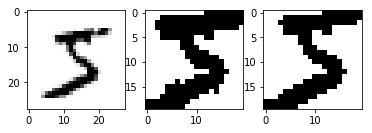

In [26]:
fig = plt.figure(figsize=(30,30))

fig, axarr = plt.subplots(1,3) 

axarr[0].imshow(train_images_raw[0], cmap='Greys')
axarr[1].imshow(train_images_sbb[0], cmap='Greys')
axarr[2].imshow(train_images_bb[0], cmap='Greys')

## Naive Bayes Performances on Transformed Images

In [27]:
def train_nb_eval_acc(train_images, train_labels, eval_images, eval_labels, density_model='Gaussian'):
    """
    Trains Naive Bayes models, apply the model, and return an accuracy.

        Parameters:
                train_images (np.array): A numpy array with the shape (N,height,width)
                train_labels (np.array): A numpy array with the shape (N,), where N is the number of samples and 
                has the int64 dtype.
                eval_images (np.array): The evaluation images with similar characteristics to train_images.
                eval_labels (np.array): The evaluation labels with similar characteristics to train_labels.
                density_model (string): A string that is either 'Gaussian' or 'Bernoulli'. 
                
        Returns:
                eval_acc (np.float): a floating number scalar between 0 and 1 that 
                represents the accuracy of the trained model on the evaluation data.
    """
    
    assert density_model in ('Gaussian', 'Bernoulli')
    
    train_images = train_images.reshape(train_images.shape[0], -1)
    eval_images = eval_images.reshape(eval_images.shape[0], -1)
    
    
    gnb = GaussianNB()
    
    # Train model X_train, Y_train
    gnb.fit(train_images, train_labels)
    
    # Predict Y labels
    y_hat = gnb.predict(eval_images)
    
    # Evaluate Accuracy
    
    eval_acc = (eval_labels == y_hat).mean()
    
    return eval_acc

# Don't mind the following lines and do not change them
train_nb_eval_acc_gauss = lambda *args, **kwargs: train_nb_eval_acc(*args, density_model='Gaussian', **kwargs)
train_nb_eval_acc_bern = lambda *args, **kwargs: train_nb_eval_acc(*args, density_model='Bernoulli', **kwargs)

In [28]:
# Performance on untouched images
acc_nbg_thr = train_nb_eval_acc(train_images_threshed, train_labels, 
                                eval_images_threshed, eval_labels, density_model='Gaussian')
acc_nbb_thr = train_nb_eval_acc(train_images_threshed, train_labels, 
                                eval_images_threshed, eval_labels, density_model='Bernoulli')

# Performance on bounding-box
acc_nbg_bb = train_nb_eval_acc(train_images_bb, train_labels, 
                                eval_images_bb, eval_labels, density_model='Gaussian')
acc_nbb_bb = train_nb_eval_acc(train_images_bb, train_labels, 
                                eval_images_bb, eval_labels, density_model='Bernoulli')

# Performance on stretched bounding-box
acc_nbg_sbb = train_nb_eval_acc(train_images_sbb, train_labels, 
                                eval_images_sbb, eval_labels, density_model='Gaussian')
acc_nbb_sbb = train_nb_eval_acc(train_images_sbb, train_labels, 
                                eval_images_sbb, eval_labels, density_model='Bernoulli')


df = pd.DataFrame([('Untouched images', acc_nbg_thr, acc_nbb_thr),
                   ('Bounding box', acc_nbg_bb, acc_nbb_bb),
                   ('Stretched bounding box', acc_nbg_sbb, acc_nbb_sbb)
                  ], columns = ['Accuracy' , 'Gaussian', 'Bernoulli'])

df

,Accuracy,Gaussian,Bernoulli
0,Untouched images,0.5491,0.5491
1,Bounding box,0.7209,0.7209
2,Stretched bounding box,0.8150,0.8150


Conclusion: Even though Naive Bayes is a very traditional algorithm, it is very powerful for classification. Unlike other algorithms, such as Nearest Neighbors, in which sample size needs to be large enough to be effective and very sensitive to incomplete data, Naive Bayes is a great technique to make probabilistic predictions. Among other benefits, Naibe Bayes classifiers are easy to implement, they are very robust to incomplete data, they are very effective with high dimensional data, and most importantly they are competitive against other techniques, such as neural networks, and decison trees.

As shown above, the more data transformation we apply to images, the better the accuracy we get for making predictions, regardless of the probability distribution - in this case whether it is Gaussian or Bernoulli